## Dynamics of microbial OTUs

In this notebook we use the multivariate AR(1) model to fit a multivariate time series of marine bacterial operational taxonomic units (OTUs).
The dataset comes from

*Martin-Platero et al. 2018. High resolution time series reveals cohesive but short lived communities in coastal plankton. Nature Communications*

First load packages and read in the dataset:

In [1]:
%matplotlib notebook
import pystan
import numpy as np
import pandas

In [2]:
DAT = pandas.read_csv('data/bacterial_OTU.csv')

Aggregate the data by phyla, which is indicated in the third column ("phylum") of the dataset:

In [3]:
phyla = np.unique(DAT['phylum']) # extract unique phyla IDs

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
PHY = pandas.DataFrame([DAT.loc[DAT['phylum']==phylum].iloc[:,8:].sum() for phylum in phyla])
# associate each row with phylum
PHY = PHY.set_index(phyla)

Now take a look to see how each phyla contributes to the total abundances:

In [4]:
PHY.sum(axis=1)

p__                        245003
p__Acidobacteria             1939
p__Actinobacteria           55012
p__Aquificae                    1
p__Bacteroidetes          1068025
p__Chlamydiae                 420
p__Chlorobi                    73
p__Chloroflexi                132
p__Cyanobacteria           225623
p__Deferribacteres              2
p__Deinococcus-Thermus        585
p__Firmicutes               27331
p__Fusobacteria             10889
p__Gemmatimonadetes             1
p__Lentisphaerae              190
p__Nitrospira                   2
p__OD1                        946
p__Planctomycetes           65740
p__Proteobacteria         1086966
p__SR1                       2029
p__Spirochaetes                23
p__Tenericutes                 53
p__Verrucomicrobia          86525
p__WS3                        219
dtype: int64

In [5]:
index_max4 = np.argsort(PHY.sum(axis=1).values)[-4:][::-1]
# for consistency with the R code, rearrange the index (now they are in order of appearance in dataset)
index_max4 = index_max4[np.array((1,0,3,2))]

PHY = PHY.iloc[index_max4]
PHY

,10N.204.37,10N.204.38,10N.204.39,10N.205.37,10N.205.38,10N.205.39,10N.206.37,10N.206.38,10N.206.39,10N.207.37,...,10N.293.39,10N.294.37,10N.294.38,10N.294.39,10N.295.37,10N.295.38,10N.295.39,10N.296.37,10N.296.38,10N.296.39
p__Bacteroidetes,913,1626,1391,1809,2253,2152,2043,2337,2344,2769,...,3004,1541,2130,1595,2413,1857,1772,1989,2135,1769
p__Proteobacteria,2476,3977,3012,4648,4882,5271,3788,4245,4150,5369,...,2230,1781,2397,1680,2010,1161,1244,2088,1379,1333
p__Cyanobacteria,870,1721,1459,985,1141,913,891,751,936,1053,...,219,56,116,98,151,101,97,109,120,81
p__,246,400,318,567,557,519,527,612,560,565,...,664,396,579,439,796,455,514,516,503,351


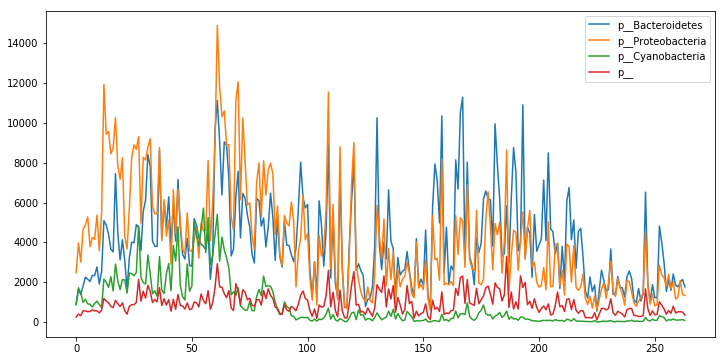

In [6]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(PHY.values.T)
ax.legend(PHY.index)
None

In [7]:
dat_PHY = {'T':PHY.shape[1], 'p':PHY.shape[0], 'Y':PHY.values}

In [8]:
mod_code = '''data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
    }
}
'''

In [9]:
mod = pystan.StanModel(model_code=mod_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b640f46b6f055782bca709a8bd79b59 NOW.


In [10]:
mcmc = mod.sampling(data=dat_PHY, iter=2000, warmup=1000)
print(mcmc)

Inference for Stan model: anon_model_5b640f46b6f055782bca709a8bd79b59.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]   0.67  1.2e-3   0.09   0.49   0.61   0.67   0.73   0.85   5784    1.0
PHI[2,1]   0.13  1.1e-3   0.09  -0.05   0.07   0.13   0.19   0.31   6443    1.0
PHI[3,1]   0.01  3.3e-4   0.03  -0.04-6.7e-3   0.01   0.03   0.06   6294    1.0
PHI[4,1]   0.08  3.0e-4   0.02   0.03   0.06   0.08   0.09   0.12   5542    1.0
PHI[1,2]   0.03  1.3e-3   0.09  -0.15  -0.03   0.03    0.1   0.21   5013    1.0
PHI[2,2]   0.78  1.2e-3   0.09   0.61   0.72   0.78   0.84   0.96   5592    1.0
PHI[3,2]   0.05  3.6e-4   0.03 7.5e-4   0.03   0.05   0.07    0.1   5345    1.0
PHI[4,2] 1.8e-3  3.0e-4   0.02  -0.04  -0.01 1.8e-3   0.02   0.04   5244    1.0
PHI[1,3]   0.18  2.0e-3   0.15  -0.12   0.08   0.19   0.28   0.48   5473    1.0
PHI[2,3]   